# Classification and Captioning Aircraft Damage Using Pretrained Models


## **Introduction**

In this project, we will classify aircraft damage using a pre-trained VGG16 model and generate captions using a Transformer-based pretrained model.

## **Project Overview**

Aircraft damage detection is essential for maintaining the safety and longevity of aircraft. Traditional manual inspection methods are time-consuming and prone to human error. This project aims to automate the classification of aircraft damage into two categories: "dent" and "crack." For this, we will utilize feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images. Additionally, we will use a pre-trained Transformer model to generate captions and summaries for the images.

## **Aim of the Project**

The goal of this project is to develop an automated model that accurately classifies aircraft damage from images. This model will be applicable in real-world damage detection within the aviation industry. Furthermore, the project will showcase how we can use a Transformer-based model to caption and summarize images, providing a detailed description of the damage.

## **Final Output**

- A trained model capable of classifying aircraft images into "dent" and "crack" categories, enabling automated aircraft damage detection.
- A Transformer-based model that generates captions and summaries of images


We will be using the [Aircraft dataset](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar).
The dataset is taken from the here (Original Source): [Roboflow Aircraft Dataset](https://universe.roboflow.com/youssef-donia-fhktl/aircraft-damage-detection-1j9qk) Provided by a Roboflow user, License: CC BY 4.


<h2>Table of Contents</h2>
 
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <p><font size="5">Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'</p>
<font size="3">
        1. <a href="#1.1-Dataset-Preparation">1.1 Dataset Preparation</a><br>
        2. <a href="#1.2-Data-Preprocessing">1.2 Data Preprocessing</a><br>
        3. <a href="#1.3-Model-Definition">1.3 Model Definition</a><br>
        4. <a href="#1.4-Model-Training">1.4 Model Training</a><br>
        5. <a href="#1.5-Visualizing-Training-Results">1.5 Visualizing Training Results</a><br>
        6. <a href="#1.6-Model-Evaluation">1.6 Model Evaluation</a><br>
        7. <a href="#1.7-Visualizing-Predictions">1.7 Visualizing Predictions</a><br>
    <br>
<p><font size="5">Part 2: Image Captioning and Summarization using BLIP Pretrained Model</p>
<font size="3">
        1. <a href="#2.1-Loading-BLIP-Model">2.1 Loading BLIP Model</a><br>
        2. <a href="#2.2-Generating-Captions-and-Summaries">2.2 Generating Captions and Summaries</a><br>
        <br>
    


## Objectives

- Use the VGG16 model for image classification.
- Prepare and preprocess image data for a machine learning task.
- Evaluate the model’s performance using appropriate metrics.
- Visualize model predictions on test data.
- Use a custom Keras layer.

## Setup


In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Suppress the tensorflow warning messages
We use the following code to  suppress the warning messages due to use of CPU architechture for tensoflow.

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Importing Required Libraries


In [3]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [4]:
# Setting the seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#### Pretrained Model

A pretrained model refers to a machine learning model that has already been trained on a large dataset, typically for a specific task, and is ready for use or fine-tuning on a new task or dataset. The key idea behind a pretrained model is that it has already learned useful patterns or features from the data it was trained on, so you don’t need to start from scratch.

- **ResNet, VGG (Image Classification):** These are pretrained models commonly used for image classification tasks. They have learned from millions of images and can be fine-tuned for specific image-related tasks.

- **BLIP (Image Captioning and Summarization):** BLIP is a pretrained model that can generate captions and summaries for images. It has already been trained on image-text pairs, so it can easily generate descriptive captions for new images.


## <a id='toc1_'> </a> [Part 1 - Classification Problem: Classifying the defect on the aircraft as 'dent' or 'crack'](#toc1_) 

### <a id='toc1_1_'></a> [1.1 Dataset Preparation](#toc1_) 

The first step is to load and prepare the dataset of aircraft images. These images are labeled either as 'dent' or 'crack'. We will also split the dataset into training, validation, and test sets.

Our goal is to train an algorithm on these images and to predict the labels for images in the test set.




**Defining configuration options**

It's time to define some model configuration options.

*  We will set the **batch size** is set to 32.
*  We will set the **number of epcohs** to 10.


In [5]:
#Setting the batch size,epochs
batch_size = 32
n_epochs = 10
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

Extracting the Dataset:


In [6]:
import tarfile
import os
import shutil

# Define the path to save the file
tar_filename = "./Dataset/aircraft_damage_dataset_v1.tar"
extracted_folder = "./aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")
    
    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")

Extracted ./Dataset/aircraft_damage_dataset_v1.tar successfully.


The folder structure looks as follows:

```python
aircraft_damage_dataset_v1/
├── train/
│   ├── dent/
│   └── crack/
├── valid/
│   ├── dent/
│   └── crack/
└── test/
    ├── dent/
    └── crack/

```



In [7]:
# Defining directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

## 1.2 Data Preprocessing

It's time to create data generators for training, validation, and testing datasets.

First, we will create ImageDataGenerators used for training, validation and testing.
The ImageDataGenerator class is part of Keras. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset  to improve model generalization. 

We will create instances of the ImageDataGenerator class. Each instance corresponds to one of the datasets: training, validation, and testing.


In [8]:
# Creating ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Next, we use flow_from_directory() method to load the images from directory and generate the training dataset:

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 300 images belonging to 2 classes.


Now, the same for the validation dataset:

In [10]:
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 96 images belonging to 2 classes.


And for the test dataset:


In [11]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 50 images belonging to 2 classes.


## 1.3 Model Definition

Here, we define the model architecture by using a pre-trained VGG16 model as the base, adding custom layers on top for binary classification of 'dent' and 'crack' types of damage.


### Loading the pre-trained model VGG16

In [12]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(img_rows,img_cols,3))

Now, we modify the VGG16 model for our specific classification task. We extract the output from the last layer of the pre-trained VGG16 model, and then create a new model with this modified output. Then we will freeze the base VGG16 model layers so that their weights will not be updated during training.


In [13]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freezing the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. We are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").


In [14]:
# Building the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

### Compiling the model

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

## 1.4 Model Training

- This section covers the process of training the model using the prepared dataset.


In [16]:
#Training the model
history=model.fit(train_generator,epochs=n_epochs,validation_data=valid_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 621s 61s/step - accuracy: 0.5367 - loss: 0.7201 - val_accuracy: 0.6042 - val_loss: 0.6338
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 570s 57s/step - accuracy: 0.7233 - loss: 0.5535 - val_accuracy: 0.6979 - val_loss: 0.5821
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 567s 61s/step - accuracy: 0.7767 - loss: 0.4737 - val_accuracy: 0.7188 - val_loss: 0.5486
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 595s 54s/step - accuracy: 0.8133 - loss: 0.4123 - val_accuracy: 0.6562 - val_loss: 0.6457
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 568s 58s/step - accuracy: 0.8800 - loss: 0.3204 - val_accuracy: 0.7083 - val_loss: 0.5098
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 548s 50s/step - accuracy: 0.8833 - loss: 0.2845 - val_accuracy: 0.7604 - val_loss: 0.4635
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 507s 52s/step - accuracy: 0.9400 - loss: 0.2125 - val_accuracy: 0.7604 - val_loss: 0.4456
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 500s 51s/step - accuracy: 0.9333 - loss: 0.1994 - val_accuracy: 0.

In [17]:
# Access the training history
train_history = model.history.history  # After training
# Saving the Model
model.save('Aircraf_DentCrack_Classifier.h5')

## 1.5 Visualizing Training Results

- After training the model, we visualize the training and validation accuracy and loss to understand the model's learning process.


### Plotting loss curves for training and validation sets


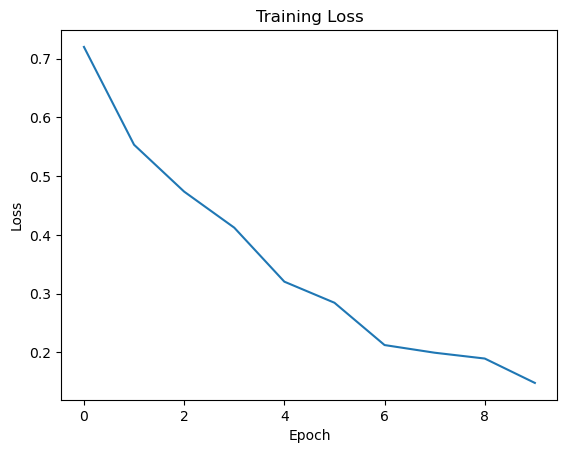

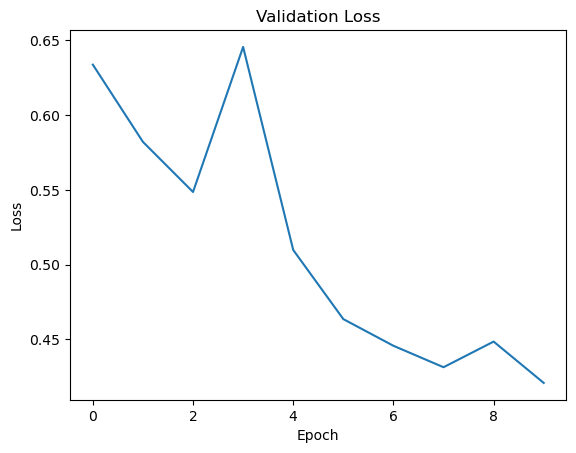

In [18]:
# Plotting the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

## Plotting accuracy curves for training and validation sets


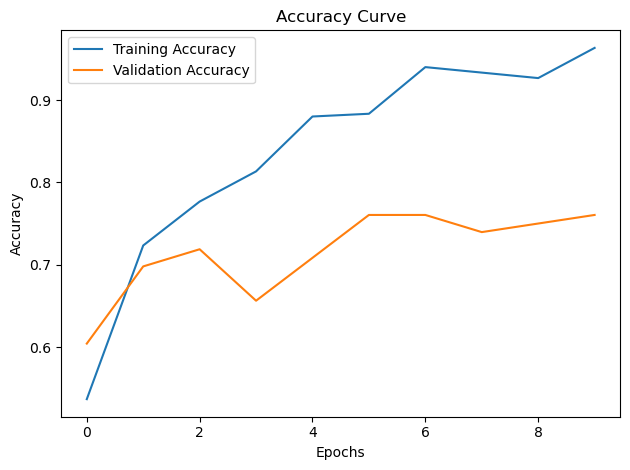

In [19]:
# Plotting accuracy for training and validation
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## 1.6 Model Evaluation

Now we evaluate the trained model on the test dataset.

In [20]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - accuracy: 0.8438 - loss: 0.6216
Test Loss: 0.6216
Test Accuracy: 0.8438


 ## 1.7 Visualizing Predictions

 Now we will isplay test images alongside their true and predicted labels.

True labels and predictions are retrieved.
Images are displayed with labels for visual inspection of model performance.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)

### Visualizing the results                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step


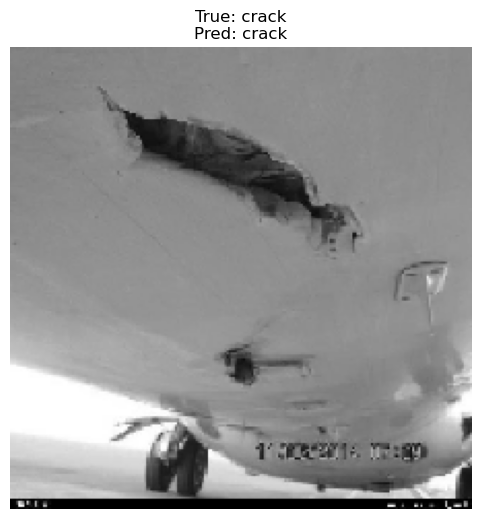

In [22]:
test_model_on_image(test_generator,model,index_to_plot=1)

## <a id='toc2_'></a>[Part 2: Image Captioning and Summarization using BLIP Pretrained Model](#toc2_)


BLIP (Bootstrapping Language-Image Pretraining) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

In this project, we will utilize the BLIP model to build a system capable of automatically generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.

In [23]:
#Loading the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

## 2.1 Loading BLIP Model


#### Load the BLIP Model and Processor from Hugging Face

- **BlipProcessor:** This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

- **BlipForConditionalGeneration:** This is the model itself, responsible for generating captions or summaries based on the processed image.


In [24]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### Custom Keras Layer: BlipCaptionSummaryLayer

Next, we define a custom `tf.keras.layers.Layer` class that takes in an image and a task input (either caption or summary) and processes the image using the BLIP model.

In [25]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


### Implementing a Helper Function to Use the Custom Keras Layer

We will also implement a helper function `generate_text` that utilizes the custom `BlipCaptionSummaryLayer` Keras layer to generate captions or summaries for a given image. The function will accept an image path and a task type (caption or summary), process the image using the BLIP model, and return the generated text.


In [26]:
def generate_text(image_path,task):
        blip_layer=BlipCaptionSummaryLayer(processor, model)
        result=blip_layer(image_path,task)
        return result

## 2.2 Generating Captions and Summaries


Now we use the `generate_text` function to generate a caption and a summary for an image.
It processes the image and prints the corresponding text output in a human-readable format.
The function makes it easy to switch between generating captions and summaries based on the task type you provide.</br>
</br>

**Note:** Generated captions/summary may not always be accurate, as the model is limited by its training data and may not fully understand new or specific images.



In [27]:
# Path to an example image 
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


#### Generating a caption for an image using the using BLIP pretrained model


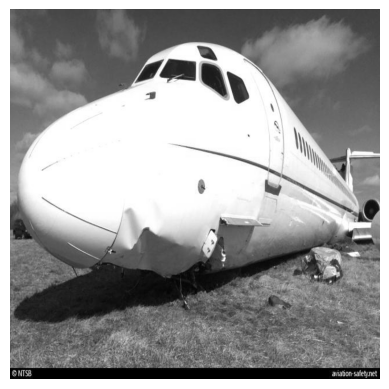

In [28]:
# We will use the following image to display Caption and Summary
# URL of the image
image_file = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_file)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [29]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [30]:
# Generating a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decoding and printing the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

Caption: this is a picture of a plane that was sitting on the ground in a field


#### Generating a summary of an image using BLIP pretrained model

In [31]:
# Generating a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decoding and printing the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Summary: this is a detailed photo showing the damage to the fuselage of the aircraft


## Author
**Filipe B. Carvalho**

**Email:** [filipebraiman@gmail.com](mailto:filipebraiman@gmail.com)  
**LinkedIn:** [linkedin.com/in/filipe-b-carvalho](https://www.linkedin.com/in/filipe-b-carvalho)  
**GitHub:** [github.com/filipe-braiman](https://github.com/filipe-braiman)  

### About Me  
Data and AI professional with experience in **AI model evaluation, data annotation, and NLP projects**, currently contributing to AI initiatives at **Huawei**. Skilled in **Python, SQL, data visualization, machine learning, AI, and dataset building**, and certified through the **IBM Data Science Professional Certificate**. Multilingual in **Portuguese, English, Spanish, Turkish, and French**, bringing a linguistic and analytical perspective to data-driven problem solving. Passionate about leveraging data and AI to create practical, high-impact solutions.

---

### Version History

| Version | Date       | Changes                         |
|:--------:|:-----------|:--------------------------------|
| 1.0      | 2025-10-29 | First publication of the notebook |
